In [1]:
elastic_rods_dir = '../../../elastic_rods/python/'
weaving_dir = '../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, optimization_visualization_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
importlib.reload(optimization_visualization_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, highlight_rod_and_joint)
import vis.fields
import matplotlib.cm as cm
import time
from optimization_visualization_helper import (compute_visualization_data_from_raw_data, get_objective_components_stage1, get_objective_components_stage2, get_objective_components_stage3, set_figure_label_and_limit, Visualization_Setting, plot_objective, plot_ribbon_component_analysis)


In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
rod_length = 0.21162395234664752
width = rod_length / 15 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('simple_hemoglobin_5_1', thickness, width, weaving_dir)
#  [ ear 214, ear 255, nose 39]

0.0705413174488825 0.004937892221421775


In [4]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.1
dsw = 0.1

In [5]:
import pickle 
import gzip

In [6]:
curved_linkage = pickle.load(gzip.open('hemoglobin_test_20201202.pkl.gz', 'r'))
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view, linkage_color='lightgreen')
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [7]:
curved_linkage.attraction_weight = 1e-5

In [8]:
def eqm_callback(prob, i):
    pass
#    curved_linkage_view.update()

In [9]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
curved_linkage_view.update()

0	0.000179907	7.74382e-08	7.74382e-08	0	0


In [10]:
def get_opposite_joint_type(curr_type):
    if curr_type == curved_linkage.joint(0).Type.A_OVER_B:
        return curved_linkage.joint(0).Type.B_OVER_A
    return curved_linkage.joint(0).Type.A_OVER_B
import structural_analysis

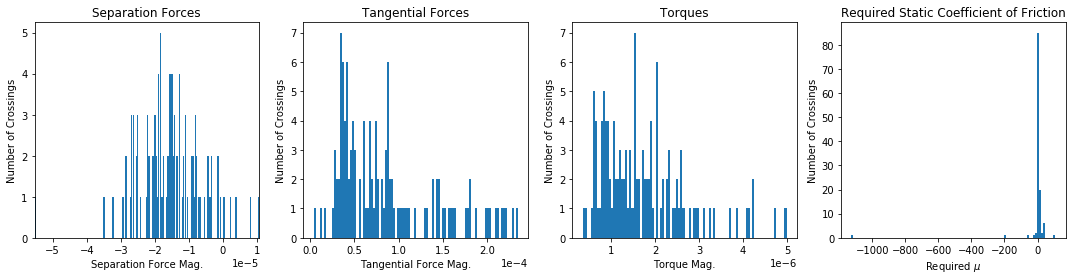

In [11]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [12]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [  7 113  81  11  53 119]
0	0.00130107	0.413005	0.413005	1	1
1	0.000676123	0.878282	0.878282	1	1
2	0.000370708	0.204313	0.204313	1	1
3	0.000307112	0.0164902	0.0164902	1	1
4	0.000271504	0.011032	0.011032	0.5	0
5	0.00023121	0.0854542	0.0854542	1	1
6	0.000208372	0.0054404	0.0054404	1	1
7	0.000199435	0.00304783	0.00304783	1	0
8	0.000186347	0.0237311	0.0237311	1	1
9	0.000182526	0.000551353	0.000551353	0.5	0
10	0.000181609	0.00724163	0.00724163	1	0
11	0.000180963	0.00174024	0.00174024	0.5	0
12	0.000180837	0.00351232	0.00351232	1	0
13	0.000180768	0.000301184	0.000301184	1	0
14	0.000180765	0.000144487	0.000144487	1	0
15	0.000180765	1.00127e-06	1.00127e-06	0.25	0
16	0.000180765	6.49535e-06	6.49535e-06	1	0
17	0.000180765	3.94955e-07	3.94955e-07	1	0


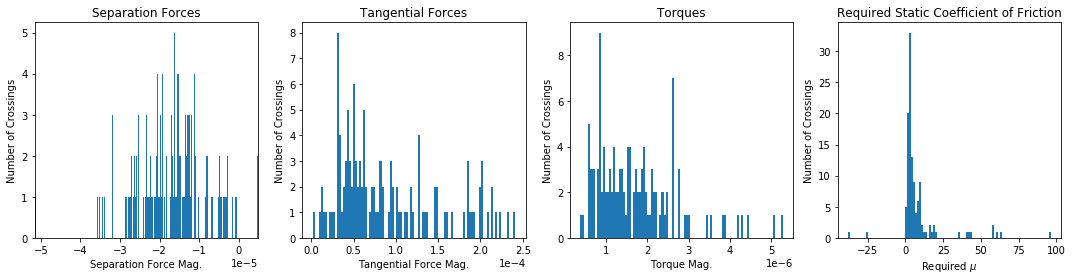

In [13]:
second_structure_view = get_structure_analysis_view(curved_linkage)
second_structure_view.show()

In [14]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [72  6]
0	0.000619074	0.244276	0.244276	0.125	0
1	0.00054472	0.21706	0.21706	0.5	0
2	0.000413938	0.634943	0.634943	1	1
3	0.000277575	0.0617518	0.0617518	1	1
4	0.000252671	0.0156074	0.0156074	0.03125	0
5	0.000250045	0.0186132	0.0186132	1	1
6	0.000233177	0.00924306	0.00924306	1	0
7	0.000197745	0.0525839	0.0525839	1	1
8	0.000189381	0.00228243	0.00228243	0.5	0
9	0.000185474	0.0205059	0.0205059	1	1
10	0.000184152	0.000875182	0.000875182	1	0
11	0.000181577	0.00410861	0.00410861	1	0
12	0.000181094	0.00279008	0.00279008	1	0
13	0.000181041	0.000600599	0.000600599	1	0
14	0.000181037	8.18497e-05	8.18497e-05	1	0
15	0.000181037	3.00185e-06	3.00185e-06	0.25	0
16	0.000181037	9.30387e-06	9.30387e-06	1	0
17	0.000181037	8.49837e-07	8.49837e-07	1	0


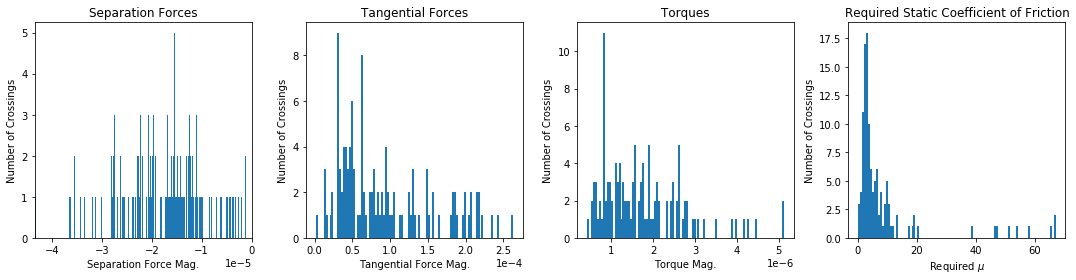

In [15]:
third_structure_view = get_structure_analysis_view(curved_linkage)
third_structure_view.show()

In [16]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_linkage.jointPositions(), curved_linkage_view, rw, sw, inner_gradTol = 1e-6, equilibrium_iter = 50)

In [17]:
optimizer, contact_opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, minRestLen=-1, contact_weight = 1e4, normalWeight = 1, torqueWeight = 1, tangentialWeight = 5, maxIter=2000)

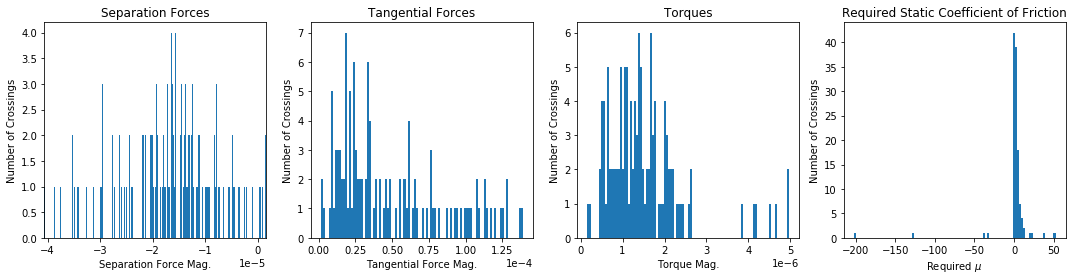

In [18]:
fourth_structure_view = get_structure_analysis_view(curved_linkage)
fourth_structure_view.show()

In [19]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [  4 114 117  24]
0	0.00101847	0.400285	0.400285	1	1
1	0.000509463	1.42349	1.42349	1	1
2	0.000313308	0.0867885	0.0867885	1	1
3	0.000295445	0.0218704	0.0218704	1	1
4	0.000277346	0.016432	0.016432	1	0
5	0.000216407	0.119588	0.119588	1	1
6	0.00019143	0.00767269	0.00767269	0.0625	0
7	0.000191139	0.0157847	0.0157847	1	1
8	0.000187191	0.00303257	0.00303257	1	0
9	0.000179483	0.0132126	0.0132126	1	1
10	0.000178955	0.000497453	0.000497453	1	0
11	0.000178382	0.00294491	0.00294491	1	0
12	0.000178306	0.000259298	0.000259298	1	0
13	0.000178304	2.23315e-05	2.23315e-05	1	0
14	0.000178304	9.63756e-07	9.63756e-07	1	0


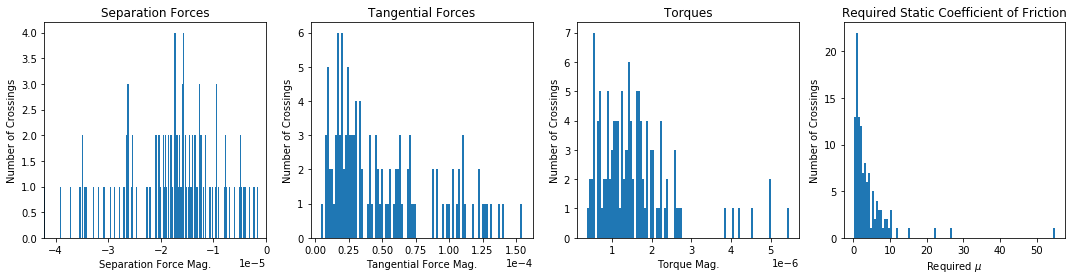

In [20]:
fifth_structure_view = get_structure_analysis_view(curved_linkage)
fifth_structure_view.show()

In [22]:
optimizer, contact_opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, minRestLen=-1, contact_weight = 1e4, normalWeight = 1, torqueWeight = 1, tangentialWeight = 5, maxIter=2000)

In [23]:
pickle.dump(curved_linkage, gzip.open('{}_contact_opt_20201210.pkl.gz'.format(io.MODEL_NAME), 'w'))